In [3]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load the training data into feature matrix, class labels, and event ids:

In [4]:
from proj1_helpers import *
DATA_TRAIN_PATH = 'train.csv' # TODO: download train data and supply path here 
#DATA_TRAIN_PATH = 'train.csv' # TODO: download train data and supply path here 
y, X, ids = load_csv_data(DATA_TRAIN_PATH)

## Data cleaning

In [7]:
from helpers import *

def standardize_badFeatures(X):
    
    # Function that calculate the mean and std of bad features without elements equal to -999
    # Then, it remplaces -999 values by zeros, zeros won't influence the train of the model... 
    mean_x = np.zeros((X.shape[1],))
    std_x = np.zeros((X.shape[1],))
    for d in range(X.shape[1]):
        idx = np.where(X[:,d] == -999)
        mean_x[d] = np.mean(np.delete(X[:,d], (idx)))
        std_x[d] = np.std(np.delete(X[:,d], (idx)))
        X[:,d] = (X[:,d]-mean_x[d])/std_x[d]
        X[idx,d] = 0
    return X, mean_x, std_x


def clean_data(X):

    # find indices of features that have at least one value -999, we call them "bad" features
    idx_badFeatures = []
    for d in range(X.shape[1]):
        if sum(X[:,d] == -999) > 0:
            idx_badFeatures.append(d)

    # separate "good" and "bad" features
    X_badFeatures = X[:,idx_badFeatures]
    X_goodFeatures = np.delete(X,(idx_badFeatures), axis=1)

    tX, mean_x, std_x = standardize(X_goodFeatures)
    tX2, mean_x2, std_x2 = standardize_badFeatures(X_badFeatures)

    # comment the 3 next lines if you want to work only with the 19 "good" features
    #tX = np.hstack((tX, tX2))
    #mean_x = np.hstack((mean_x, mean_x2))
    #std_x = np.hstack((std_x, std_x2))
    
    return tX, mean_x, std_x

tX, mean_x, std_x = clean_data(X)

In [6]:
# look for outliers (> 40*std)
#outliers = np.where(tX > 40)
# here we see that our single outlier is in fact a higgs boson event...
# should we keep it ???
#print(outliers[0], y[outliers[0]])
#plt.boxplot(tX)
#np.sum(y == 1)/len(y), np.sum(y == -1)/len(y)


#Is there samples that are identical ?
#ncols = tX.shape[1]
#dtype = tX.dtype.descr * ncols
#struct = tX.view(dtype)

#uniq, idx = np.unique(struct, return_index=True)
#tX = uniq.view(tX.dtype).reshape(-1, ncols)

#print(tX.shape)
            

# Ridge regression

In [23]:
import myFunctions as my
from plots import bias_variance_decomposition_visualization

def cross_validation(y, x, k_indices, k, lamb):
    """return the loss of ridge regression."""
    # get k'th subgroup in test, others in train: TODO
    tx_tr = x[np.delete(k_indices, (k), axis=0).flatten()]
    y_tr = y[np.delete(k_indices, (k), axis=0).flatten()]
    tx_te = x[k_indices[k]]
    y_te = y[k_indices[k]]
    
    
    # regression/classification method
    #w = my.ridge_regression(y_tr, tx_tr, lamb)
    w = my.ridge_regression(y_tr, tx_tr, lamb)
    
    # calculate the loss for train and test data: TODO
    loss_tr = my.compute_loss(y_tr, tx_tr, w)
    loss_te = my.compute_loss(y_te, tx_te, w)
    
    #y_tr_pred = predict_labels(w, tx_tr)
    #loss_tr = len(np.nonzero(y_tr_pred-y_tr)[0])/len(y_tr)
    #loss2_tr = np.sum(np.abs(y_tr-y_tr_pred)/2)/len(y_tr)
    #y_te_pred = predict_labels(w, tx_te)
    #loss_te = len(np.nonzero(y_te_pred-y_te)[0])/len(y_te)
    #loss2_te = np.sum(np.abs(y_te-y_te_pred)/2)/len(y_te)
    
    
    return loss_tr, loss_te

def cross_validation_demo(y, X):
    # parameters
    seed = 56
    k_fold = 10
    
    # hyperparameters
    degrees = [1, 2, 3]
    lambdas = np.logspace(-5, 2, 15)
    
    # split data in k fold
    k_indices = my.build_k_indices(y, k_fold, seed)
    
    
    # define lists to store the loss of training data and test data
    rmse_tr = np.zeros((len(degrees),len(lambdas)))
    rmse_te = np.zeros((len(degrees),len(lambdas)))
    var_tr = np.zeros((len(degrees),len(lambdas)))
    var_te = np.zeros((len(degrees),len(lambdas)))
    
    # Hyperparameter 1
    for ind, degree in enumerate(degrees):
        print(ind)
        # Build polynomial function
        tX = my.build_poly(X, degree)
        
        loss_tr = np.zeros((len(lambdas),))
        loss_te = np.zeros((len(lambdas),))
        
        for ind2, lamb in enumerate(lambdas):
        
            # Cross-validation
            for k in range(k_fold):
                loss_tr[k], loss_te[k] = cross_validation(y, tX, k_indices, k, lamb)
                
            rmse_tr[ind,ind2] = np.mean(loss_tr)
            rmse_te[ind,ind2] = np.mean(loss_te)
            #var_tr[ind] = np.std(loss_tr)
            #var_te[ind] = np.std(loss_te)
        
        #best_rmse.append(min(rmse_te))
        #best_lambda.append(lambdas[np.argmin(np.array(rmse_te))])
        
    #bias_variance_decomposition_visualization(lambdas, rmse_tr.T, rmse_te.T)    
    return rmse_tr, rmse_te, var_tr, var_te, degrees, lambdas

rmse_tr, rmse_te, var_tr, var_te, degrees, lambdas = cross_validation_demo(y, tX)


    
#plt.plot(degrees, rmse_tr, marker=".", color='b', label='train error')
#plt.plot(degrees, rmse_te, marker=".", color='r', label='test error')
#plt.xlabel("Degree")
#plt.ylabel("MAE")
#plt.title("10-folds CV, Least Squares")
#plt.legend(loc=2)
#plt.grid(True)


0
1
2


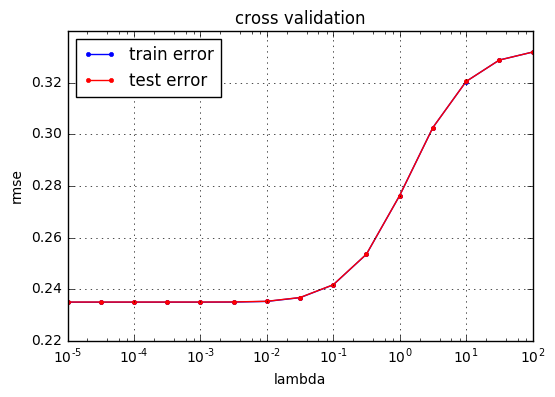

In [15]:
from plots import *

cross_validation_visualization(lambdas, rmse_tr[0].T, rmse_te[0].T) 

In [16]:
degree = 2
lamb = 1
final_X = my.build_poly(tX, degree)
w = my.ridge_regression(y, final_X, lamb)
y_pred = predict_labels(w, final_X)
loss = len(np.nonzero(y_pred-y)[0])/len(y)
loss

0.279956

## Generate predictions and save ouput in csv format for submission:

In [20]:
DATA_TEST_PATH = '/Users/akhileshgotmare/Desktop/Git_Junta/data-ml-course-project1/test.csv' # TODO: download train data and supply path here 
_, X_test, ids_test = load_csv_data(DATA_TEST_PATH)

In [21]:
tX_test, mean_xtest, std_xtest = clean_data(X_test)
final_X_test = my.build_poly(tX_test, degree)

In [22]:
OUTPUT_PATH = 'results.csv' # TODO: fill in desired name of output file for submission
y_pred = predict_labels(w, final_X_test)
create_csv_submission(ids_test, y_pred, OUTPUT_PATH)